Candidate Site Identification for Classification
===

Identify of candidate sites for the purposes of broader classification.

Using these sampling restrictions:
 - Health condition is "cancer"
 - Site's "isDeleted" != 1
 - Age of site is "adult" or "teen"
 - Site's createdAt > 2009-01-01
 - Site's last journal post is < 2016-04-01
 - Last journal createdAt - first journal createdAt > 1 month
 - Num journals in the site >= 5
 - Created by the patient 
     * We use the proportion of posts that are patient-authored according to the authorship classifier.
     * We require that 95% of the posts are patient-authored.
     * We are currently assessing if this threshold should be lowered or increased in complexity in some way.

Previously, we had also required the following:
- If authorship annotations are present for the site, we require the ratio of P to CG/PCG authored posts to be > 50%.
- The site's "isForSelf" key was set.

In [4]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

import datetime as dt
import time

from collections import Counter

import json
import os
import re
import random
import itertools
import multiprocessing as mp
from IPython.core.display import display, HTML
import datetime as dt

import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm

In [5]:
# set filepath for writing
working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites"
valid_classification_sites_filename = os.path.join(working_dir, "valid_classification_sites.txt")
valid_sites_filtered_filename = os.path.join(working_dir, "valid_classification_sites_filtered.txt")

In [53]:
# we also save some figures....
image_dir = "/home/srivbane/levon003/repos/qual-health-journeys/chi2019_tex/figures"

In [3]:
!wc -l {working_dir}/* | sort -nr

   115221 total
    58362 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/valid_classification_sites.txt
    24014 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/valid_sites_with_50_pct_patient_journals.txt
    16563 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/valid_sites_with_75_pct_patient_journals.txt
     8409 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/valid_sites_with_90_pct_patient_journals.txt
     4945 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/valid_classification_sites_filtered.txt
      999 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/active_learning_set_1000.txt
      999 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/active_learnin

In [4]:
# read the previosuly identified sites (if the file exists already)
if os.path.exists(valid_sites_filtered_filename):
    with open(valid_sites_filtered_filename, 'r') as infile:
        valid_sites = [int(line.strip()) for line in infile.readlines() if line.strip() != ""]
else:
    valid_sites = []
len(valid_sites)

4946

## Load Site Data and Get Access to Journal Database

In [6]:
# load the site dataframe
working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/extract_site_features"
feathered_site_df_filename = os.path.join(working_dir, "site_scrubbed.df")
df = pd.read_feather(feathered_site_df_filename)

In [7]:
len(df)

588210

In [9]:
def get_db():
    journal_wd="/home/srivbane/shared/caringbridge/data/derived/sqlite"
    db_filename = os.path.join(journal_wd, "journal.db")
    db = sqlite3.connect(
            db_filename,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db


def get_journal_text(site_id, journal_oid):
    try:
        db = get_db()
        cursor = db.execute("""SELECT body 
                                FROM journal
                                WHERE site_id = ? AND journal_oid = ?""", 
                            (site_id, journal_oid))
        body = cursor.fetchone()
        assert body is not None
        body_text = body['body']
        return body_text
    finally:
        db.close()
        
def get_site_journal_oids(site_id):
    try:
        db = get_db()
        cursor = db.execute("""SELECT journal_oid 
                                FROM journal
                                WHERE site_id = ?""", 
                            (site_id,))
        result = cursor.fetchall()
        journal_oids = [r['journal_oid'] for r in result]
        return journal_oids
    finally:
        db.close()
        
def get_site_journals(site_id, columns=["*"]):  # directly returns the journal rows associated with the given site_id
    try:
        db = get_db()
        columns_string = ",".join(columns)
        cursor = db.execute("""SELECT {columns}
                                FROM journal
                                WHERE site_id = ?""".format(columns=columns_string), 
                            (site_id,))
        journals = cursor.fetchall()
        return journals
    finally:
        db.close()

## Identify Candidate Sites

Filter down to only sites of interest according to criteria.

In [10]:
# include only cancer sites
c_df = df[df["healthCondition_category"] == "Cancer"]
len(c_df)

104500

In [11]:
# include only non-deleted sites
c_df = c_df[c_df["isDeleted"] != 1]
len(c_df)

97592

In [12]:
# include only adult- and teen-aged sites
valid_ages = ['adult', 'teen']
c_df = c_df[c_df["age"].isin(valid_ages)]
len(c_df)

88712

In [13]:
# include only sites since 2009
earliest_valid_date = dt.datetime(year=2009,month=1,day=1)
earliest_valid_date_timestamp = earliest_valid_date.replace(tzinfo=dt.timezone.utc).timestamp() * 1000
earliest_valid_date_timestamp
c_df = c_df[c_df["createdAt"] > earliest_valid_date_timestamp]
len(c_df)

87360

In [14]:
# include only sites created by the patient
# note that this cuts out a huge number of sites; the best way to increase our data size would be the addition of an authorship classifier
#c_df = c_df[c_df["isForSelf"] == 1.0]
#len(c_df)

In [15]:
# now, inspect journal-level features to identify valid sites

skip = True
if not skip:
    valid_sites = []
    journal_counts = []

    latest_valid_date = dt.datetime(year=2016,month=4,day=1)
    latest_valid_date_timestamp = latest_valid_date.replace(tzinfo=dt.timezone.utc).timestamp() * 1000

    min_site_time = 1000 * 60 * 60 * 24 * 30 # 30 days, in milliseconds

    for site_id in tqdm(c_df["_id"]):
        journals = get_site_journals(site_id, columns=["createdAt"])

        # include only sites with at least 5 journals
        if len(journals) < 5:
            continue

        # include only sites with last journal post created before 2016/04/01
        if journals[-1]['createdAt'] > latest_valid_date_timestamp:
            continue

        # include only sites that lasted at least 30 days
        diff = journals[-1]['createdAt'] - journals[0]['createdAt']
        if diff <= min_site_time:
            continue

        valid_sites.append(site_id)
        journal_counts.append(len(journals))
    len(valid_sites)

In [16]:
# an alternative computation on the journal-level features using a pre-saved dataframe
site_survival_working_dir = "/home/srivbane/shared/caringbridge/data/projects/classify_health_condition/vw_experiments"
site_survival_filename = os.path.join(site_survival_working_dir, "site_survival_time.csv")
col_names = ("siteId", 
             "siteCreatedAt", 
             "siteUpdatedAt", 
             "firstJournalCreatedAt", 
             "lastJournalCreatedAt",
             "numJournals", 
             "numJournalsFound")
survival_df = pd.read_csv(site_survival_filename, header=None, names=col_names)
assert len(survival_df) == len(df)

valid_sites = []
journal_counts_dict = {}

latest_valid_date = dt.datetime(year=2016,month=4,day=1)
latest_valid_date_timestamp = latest_valid_date.replace(tzinfo=dt.timezone.utc).timestamp() * 1000

earliest_valid_date = dt.datetime(year=2009,month=1,day=1)
earliest_valid_date_timestamp = earliest_valid_date.replace(tzinfo=dt.timezone.utc).timestamp() * 1000

min_site_time = 1000 * 60 * 60 * 24 * 30 # 30 days, in milliseconds
max_site_time = 1000 * 60 * 60 * 24 * 365 * 8 # 8 years, in milliseconds
# the maximum site time is really just included to remove likely-erroneous outliers with unexpected timing info

for site_id in tqdm(c_df["_id"]):
    tmp_df = survival_df[survival_df["siteId"] == site_id]
    assert len(tmp_df) == 1
    row = tmp_df.iloc[0]
    
    # include only sites with at least 5 journals
    if row['numJournalsFound'] < 5:
        continue
    
    # include only sites with last journal post created before 2016/04/01
    if row['lastJournalCreatedAt'] * 1000 > latest_valid_date_timestamp:
        continue
        
    # include only sites with first journal post created after 2009/01/01
    if row['firstJournalCreatedAt'] * 1000 < earliest_valid_date_timestamp:
        continue
    
    # include only sites that lasted at least 30 days
    diff = row['lastJournalCreatedAt'] * 1000 - row['firstJournalCreatedAt'] * 1000
    if diff <= min_site_time:
        continue
    if diff >= max_site_time:
        continue
        
    valid_sites.append(site_id)
    journal_counts_dict[site_id] = row['numJournalsFound']
len(valid_sites)

100%|██████████| 87360/87360 [02:14<00:00, 648.83it/s]


58363

#### Save the valid sites before author type filtering

In [115]:
# save the valid sites to an intermediate file before final filtering by author type
with open(valid_classification_sites_filename, 'w') as outfile:
    outfile.write("\n".join([str(sid) for sid in valid_sites]))
print("Finished.")

Finished.


#### Bring in the author type classifier's results

In [17]:
site_proportions_filepath = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/site_proportions.csv"
author_df = pd.read_csv(site_proportions_filepath)
author_df.head(n=5)

,site_id,proportion_patient_authored
0,104723,0.000000
1,104744,0.880000
2,104745,0.026316
3,104748,0.000000
4,104753,0.092308


In [18]:
def save_threshold_list(sites, threshold, output_filepath):
    filtered_sites = []
    for site_id in tqdm(valid_sites):
        row = author_df['proportion_patient_authored'][author_df['site_id'] == site_id]
        if len(row) == 1:
            proportion_patient_authored = row.iloc[0]
        elif len(row) == 0:  # This site isn't in the list, so treat it as 0% patient-authored
            #print(site_id, row)
            proportion_patient_authored = 0
        else:
            raise ValueError("Multiple matches for siteId.")
        if proportion_patient_authored >= threshold:
            filtered_sites.append(site_id)
    with open(output_filepath, 'w') as outfile:
        outfile.write("\n".join([str(sid) for sid in filtered_sites]))
    print(f"Wrote sites clearing threshold {threshold} to file '{output_filepath}'.")

In [118]:
thresholds = [0.5, 0.75, 0.9]
working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites"
for threshold in thresholds:
    filename = "valid_sites_with_%.0f_pct_patient_journals.txt" % (threshold * 100)
    output_filepath = os.path.join(working_dir, filename)
    save_threshold_list(valid_sites, threshold, output_filepath)

  0%|          | 200/58363 [00:00<00:29, 1998.15it/s]

Wrote sites clearing threshold 0.5 to file '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/valid_sites_with_50_pct_patient_journals.txt'.


  0%|          | 200/58363 [00:00<00:29, 1992.45it/s]

Wrote sites clearing threshold 0.75 to file '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/valid_sites_with_75_pct_patient_journals.txt'.


100%|██████████| 58363/58363 [00:29<00:00, 2010.33it/s]

Wrote sites clearing threshold 0.9 to file '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/valid_sites_with_90_pct_patient_journals.txt'.


In [19]:
patient_authorship_threshold = 0.95

to_trim = []
for site_id in tqdm(valid_sites):
    row = author_df['proportion_patient_authored'][author_df['site_id'] == site_id]
    if len(row) == 1:
        proportion_patient_authored = row.iloc[0]
    elif len(row) == 0:  # This site isn't in the list, so treat it as 0% patient-authored
        #print(site_id, row)
        proportion_patient_authored = 0
    else:
        raise ValueError("Multiple matches for siteId.")
    if proportion_patient_authored < patient_authorship_threshold:
        to_trim.append(site_id)
print("Will trim %d sites leaving %d candidate sites." % (len(to_trim), len(valid_sites) - len(to_trim)))

100%|██████████| 58363/58363 [00:32<00:00, 1804.78it/s]

Will trim 53417 sites leaving 4946 candidate sites.


In [20]:
for site_id in to_trim:
    valid_sites.remove(site_id)
len(valid_sites)

4946

#### Bring in author type annotations as a "trump card" (?)

In [121]:
# maybe we should just rely on the classifier and not do any manual exclusions based on tags?
# Decision: Yes.
skip_manual_annotation_exclusions = True

In [122]:
annotation_web_client_database = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/cbAnnotator.sqlite"


def get_annotation_db():
    db = sqlite3.connect(
            annotation_web_client_database,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db


def get_author_annotations(site_id):
    try:
        db = get_annotation_db()
        cursor = db.execute(
            """SELECT data 
                FROM journalAnnotation 
                WHERE annotation_type = "journal_author_type" AND site_id = ? 
                GROUP BY journal_oid
                ORDER BY id DESC""", (site_id,)
        )
        journal_author_annotations = cursor.fetchall()
        annotation_strings = [a['data'] for a in journal_author_annotations]
        return annotation_strings
    finally:
        db.close()


def get_site_patient_authorship_ratio(site_id):
    # returns None if the given site has no author annotations
    author_annotations = get_author_annotations(site_id)
    counts = Counter(author_annotations)
    p_count = counts['p'] if 'p' in counts else 0
    cg_count = counts['cg'] if 'cg' in counts else 0
    pcg_count = counts['pcg'] if 'pcg' in counts else 0
    total_valid_annotations = p_count + cg_count + pcg_count
    if total_valid_annotations == 0:
        return None
    ratio = p_count / total_valid_annotations
    return ratio
    

def is_site_authorship_valid(site_id, patient_proportion_required=0.5):
    # returns true if the proportion of patient-authored posts is greater than 0.5, and false otherwise
    ratio = get_site_patient_authorship_ratio(site_id)
    return ratio is None or ratio >= 0.5


# Test site
get_site_patient_authorship_ratio(877534)

0.125

In [123]:
# Trim valid sites based on authorship annotations
if not skip_manual_annotation_exclusions:
    to_trim = []
    for site_id in tqdm(valid_sites):
        if not is_site_authorship_valid(site_id):
            to_trim.append(site_id)
    for site_id in to_trim:
        valid_sites.remove(site_id)
    print(len(valid_sites))

#### Save the valid sites

In [124]:
# save the valid sites to a file
with open(valid_sites_filtered_filename, 'w') as outfile:
    outfile.write("\n".join([str(sid) for sid in valid_sites]))
print("Finished.")

Finished.


## Visualize Candidate Site Features

Graphs and summary stats describing the selected sites.

In [21]:
import sys
sys.path.append("../annotation_data")
from utils import *
valid_sites = get_valid_sites_filtered()
len(valid_sites)

4946

In [22]:
# do some quick summary statistics on the journal counts in the valid sites
journal_counts = [journal_counts_dict[site_id] for site_id in valid_sites]
from scipy import stats
stats.describe(journal_counts)

DescribeResult(nobs=4946, minmax=(5.0, 1395.0), mean=32.065709664375255, variance=1911.8320817713, skewness=10.371707777700294, kurtosis=227.90522128075207)

In [23]:
# median, mean, and standard deviation of the number of journals in the selected sites
np.median(journal_counts), np.mean(journal_counts), np.std(journal_counts)

(22.0, 32.065709664375255, 43.72008166405342)

In [24]:
# percentiles of the number of journal counts
np.percentile(journal_counts, [5, 10, 25, 50, 75, 90, 95])

array([ 6.  ,  7.  , 11.  , 22.  , 37.  , 63.5 , 90.75])

In [98]:
np.sum(journal_counts)

158597.0

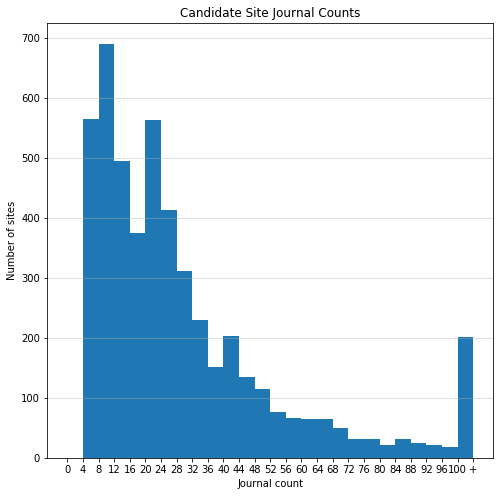

In [25]:
title = "Candidate Site Journal Counts"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = [min(journal_counts_dict[site_id], 101) for site_id in valid_sites]
patches = plt.hist(x, range=(0, 104), bins=26)
ax.set_title(title)
ax.set_xlabel("Journal count")
ax.set_ylabel("Number of sites")

ax.set_xticks([i for i in range(0, 108, 4)])
ax.set_xticklabels([str(i) if i != 104 else "+" for i in range(0, 108, 4)])

#ax.set_yticks([i for i in range(0, 430, 10)])

ax.grid(axis="y", alpha=0.5)
plt.show()

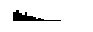

In [95]:
title = "journal counts"
fig, ax = pl.subplots(1, num=title, figsize=(1,0.4), squeeze=True)

x = [min(journal_counts_dict[site_id], 101) for site_id in valid_sites]
patches = plt.hist(x, range=(0, 100), bins=26, align="left", color="black")
#plt.ylim(0, y_limit)

# plot the mean as a black line
#m = np.mean(x)
#std = np.std(x)
#summary_text = "M=%.2f\\\\ SD=%.2f" % (m, std)
#print(summary_text)

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_shortfilename = "journal_updates_summary_hist_short.pdf"
image_filename = os.path.join(image_dir, image_shortfilename)
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()

In [26]:
# get the subset of the site df that contains only the valid sites
df_subset = df[df["_id"].isin(valid_sites)]
len(df_subset)

4946

In [27]:
# get the subset of the survival df that contains only the valid sites
survival_df_subset = survival_df[survival_df["siteId"].isin(valid_sites)]
len(survival_df_subset)

4946

In [28]:
# Add urls to the annotation client, for convenience
def get_url(site_id, port=5000):
    url = "http://127.0.0.1:%d/siteId/%d" % (port, site_id)
    return '<a href="{}">{}</a>'.format(url, url)

df_subset['annotation_url'] = [get_url(site_id) for site_id in df_subset["_id"]]

/home/srivbane/levon003/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


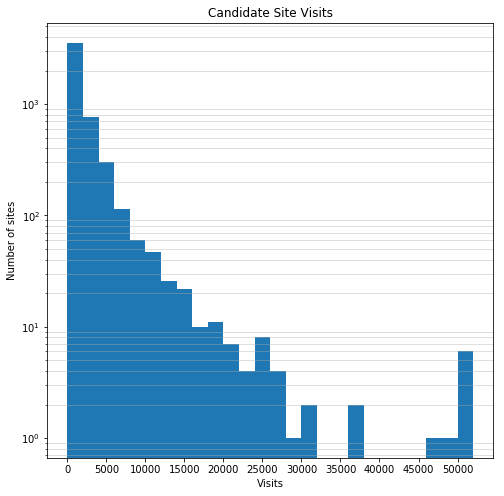

In [29]:
title = "Candidate Site Visits"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = [min(visits, 50001) for visits in df_subset["visits"]]
patches = plt.hist(x, log=True, bins=26, range=(0,52000))#, range=(0, 104), bins=26)
ax.set_title(title)
ax.set_xlabel("Visits")
ax.set_ylabel("Number of sites")

ax.set_xticks([i for i in range(0, 52000, 5000)])

ax.grid(axis="y", which="minor", alpha=0.5)
plt.show()

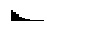

In [96]:
title = "journal counts"
fig, ax = pl.subplots(1, num=title, figsize=(1,0.4), squeeze=True)

x = [min(visits, 50001) for visits in df_subset["visits"]]
patches = plt.hist(x, log=False, bins=26, range=(0,10000), align="left", color="black")
#plt.ylim(0, y_limit)

# plot the mean as a black line
#m = np.mean(x)
#std = np.std(x)
#summary_text = "M=%.2f\\\\ SD=%.2f" % (m, std)
#print(summary_text)

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_shortfilename = "site_visits_summary_hist_short.pdf"
image_filename = os.path.join(image_dir, image_shortfilename)
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()

In [30]:
stats.describe(df_subset["visits"]), np.median(df_subset["visits"]), np.std(df_subset["visits"])

(DescribeResult(nobs=4946, minmax=(3.0, 120852.0), mean=2101.0384148807116, variance=17145579.977088206, skewness=10.91631024395993, kurtosis=219.23399074999944),
 1017.5,
 4140.303542290242)

#### Site Survival Time

In [31]:
def get_month(survival_df, site_id):
    single_entry_df = survival_df[survival_df["siteId"] == site_id]
    if len(single_entry_df) != 1:
        raise ValueError("Invalid site id %d." % site_id)
    site_survival = single_entry_df.iloc[0]
    end_date = site_survival['lastJournalCreatedAt']
    start_date = site_survival['firstJournalCreatedAt']
    if end_date < start_date:
        raise ValueError("Invalid site timing info.")
    survival_time = end_date - start_date
    one_month = 60 * 60 * 24 * 30
    approx_months_survived = survival_time / one_month
    return approx_months_survived
site_survival_times = [get_month(survival_df_subset, site_id) for site_id in valid_sites]
site_survival_times[:10]

[15.00740663580247,
 14.0642762345679,
 10.615981481481482,
 23.088961419753087,
 36.773773148148145,
 37.97802083333333,
 27.38342901234568,
 4.763890432098766,
 65.96475154320987,
 6.170110339506173]

In [32]:
stats.describe(site_survival_times)

DescribeResult(nobs=4946, minmax=(1.000138888888889, 86.00818672839506), mean=12.80852303324984, variance=175.5041743768222, skewness=2.1674728824456295, kurtosis=5.055594827696453)

In [33]:
np.median(site_survival_times), np.mean(site_survival_times), np.std(site_survival_times)

(8.222508294753087, 12.80852303324984, 13.24645953883788)

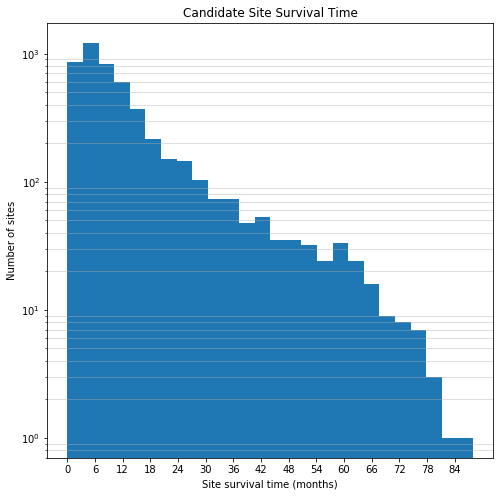

In [34]:
title = "Candidate Site Survival Time"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = site_survival_times #[min(site_survival_time, 8 * 12) for site_survival_time in site_survival_times]
month_range = 7 * 12 + 4 #2009-01 to 2016-04 is the max number of months
patches = plt.hist(x, log=True, bins=26, range=(0,7*12+4))#, range=(0, 104), bins=26)
ax.set_title(title)
ax.set_xlabel("Site survival time (months)")
ax.set_ylabel("Number of sites")

ax.set_xticks([i for i in range(0, 7*12 + 4, 6)])

ax.grid(axis="y", which="minor", alpha=0.5)
plt.show()

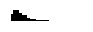

In [97]:
title = "site survival"
fig, ax = pl.subplots(1, num=title, figsize=(1,0.4), squeeze=True)

x = site_survival_times #[min(site_survival_time, 8 * 12) for site_survival_time in site_survival_times]
month_range = 7 * 12 + 4 #2009-01 to 2016-04 is the max number of months
patches = plt.hist(x, log=False, bins=26, range=(0,5*12), align="left", color="black")
#patches = plt.hist(x, log=False, bins=26, range=(0,10000), align="left", color="black")
#plt.ylim(0, y_limit)

# plot the mean as a black line
#m = np.mean(x)
#std = np.std(x)
#summary_text = "M=%.2f\\\\ SD=%.2f" % (m, std)
#print(summary_text)

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_shortfilename = "survival_time_summary_hist_short.pdf"
image_filename = os.path.join(image_dir, image_shortfilename)
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()

In [35]:
# longest site?
i = np.argmax(site_survival_times)
site_id = valid_sites[i]
site_survival = survival_df_subset[survival_df_subset['siteId'] == site_id].iloc[0]
(dt.datetime.utcfromtimestamp(site_survival['firstJournalCreatedAt']),
dt.datetime.utcfromtimestamp(site_survival['lastJournalCreatedAt']),
                             site_survival['numJournalsFound'])

(datetime.datetime(2009, 1, 16, 19, 1, 57),
 datetime.datetime(2016, 2, 10, 0, 55, 37),
 117.0)

#### Health condition

In [36]:
health_condition_counter = Counter(df_subset['healthCondition_name'])
health_condition_counter.most_common()

[('Breast Cancer', 2752),
 ('Lymphoma', 597),
 ('Cancer', 254),
 ('Colorectal Cancer', 225),
 ('Leukemia', 209),
 ('Ovarian Cancer', 169),
 ('Lung Cancer', 168),
 ('Myeloma Cancer', 120),
 ('Brain Cancer', 69),
 ('Other', 62),
 ('Thyroid Cancer', 62),
 ('Skin/Melanoma Cancer', 52),
 ('Oral Cancer', 51),
 ('Pancreatic Cancer', 48),
 ('Stomach/Esophageal Cancer', 24),
 ('Osteosarcoma', 20),
 ('Liver Cancer', 19),
 ('Kidney/Bladder Cancer', 18),
 ('Prostate Cancer', 18),
 ('Endometrial (Uterine)', 5),
 ('not provided', 3),
 ('Neuroblastoma', 1)]

In [37]:
assert sum([t[1] for t in health_condition_counter.most_common()]) == len(valid_sites)

In [38]:
health_condition_dict = {condition: count for condition, count in health_condition_counter.most_common()}
not_specified_list = ['Cancer', 'not provided']
other_threshold = 65  # include a health condition in the count for 'Other' if it fails to clear this count
# the other_threshold was set from an inspection of the output of the counter above

for cond_name in list(health_condition_dict.keys()):
    if cond_name != 'Other' and cond_name not in not_specified_list and health_condition_dict[cond_name] < other_threshold:
        health_condition_dict['Other'] += health_condition_dict[cond_name]
        del health_condition_dict[cond_name]

health_condition_dict['Not Specified'] = 0
for not_spec_name in not_specified_list:
    health_condition_dict['Not Specified'] += health_condition_dict[not_spec_name]
    del health_condition_dict[not_spec_name]

sorted_filtered_conditions = sorted([(condition, count) for condition, count in health_condition_dict.items()], key=lambda tup: tup[1], reverse=True)
sorted_filtered_conditions

[('Breast Cancer', 2752),
 ('Lymphoma', 597),
 ('Other', 380),
 ('Not Specified', 257),
 ('Colorectal Cancer', 225),
 ('Leukemia', 209),
 ('Ovarian Cancer', 169),
 ('Lung Cancer', 168),
 ('Myeloma Cancer', 120),
 ('Brain Cancer', 69)]

In [39]:
print("\\begin{tabular}[c]{@{}rlrl@{}}")
halfway = len(sorted_filtered_conditions) // 2
inds = zip(range(0, halfway), range(halfway, len(sorted_filtered_conditions)))
for i, j in inds:
    cond1, count1 = sorted_filtered_conditions[i]
    pct1 = count1 / len(valid_sites) * 100
    cond2, count2 = sorted_filtered_conditions[j]
    pct2 = count2 / len(valid_sites) * 100
    print("%s & %d (%.1f\\%%) & %s & %d (%.1f\\%%) \\\\" % (cond1, count1, pct1, cond2, count2, pct2))
print("\\end{tabular}")

\begin{tabular}[c]{@{}rlrl@{}}
Breast Cancer & 2752 (55.6\%) & Leukemia & 209 (4.2\%) \\
Lymphoma & 597 (12.1\%) & Ovarian Cancer & 169 (3.4\%) \\
Other & 380 (7.7\%) & Lung Cancer & 168 (3.4\%) \\
Not Specified & 257 (5.2\%) & Myeloma Cancer & 120 (2.4\%) \\
Colorectal Cancer & 225 (4.5\%) & Brain Cancer & 69 (1.4\%) \\
\end{tabular}


In [40]:
cond_set = set(df_subset['healthCondition_name'])
for cond in ['Cancer', 'Other', 'not provided']:
    cond_set.remove(cond)
cond_list = list(cond_set)
cond_list.sort(key=lambda cond: health_condition_counter[cond], reverse=True)
", ".join(cond_list)

'Breast Cancer, Lymphoma, Colorectal Cancer, Leukemia, Ovarian Cancer, Lung Cancer, Myeloma Cancer, Brain Cancer, Thyroid Cancer, Skin/Melanoma Cancer, Oral Cancer, Pancreatic Cancer, Stomach/Esophageal Cancer, Osteosarcoma, Liver Cancer, Prostate Cancer, Kidney/Bladder Cancer, Endometrial (Uterine), Neuroblastoma'

In [41]:
Counter(df_subset['age']).most_common()

[('adult', 4908), ('teen', 38)]

In [42]:
# it's possible we need to be omitting the non-adult sites from consideration?
# we produce a view of the non-adult sites including their annotation urls
# the original result of this analysis was manually annotating authorship on these sites to eliminate non-patient-authored sites
nonadult = df_subset[df_subset['age'] != 'adult'][['_id', 'age', 'visits', 'annotation_url']]
nonadult = nonadult.sort_values(by=['age', 'visits'], ascending=False)

pd.set_option('display.max_colwidth', -1)  # allow the entirety of the url to show by removing column width limits
HTML(nonadult.to_html(escape=False, max_rows=20))

,_id,age,visits,annotation_url
213601,452609,teen,36637.0,http://127.0.0.1:5000/siteId/452609
138199,286230,teen,12666.0,http://127.0.0.1:5000/siteId/286230
265307,560195,teen,11696.0,http://127.0.0.1:5000/siteId/560195
367099,816652,teen,7299.0,http://127.0.0.1:5000/siteId/816652
318441,667325,teen,6998.0,http://127.0.0.1:5000/siteId/667325
186864,831764,teen,6113.0,http://127.0.0.1:5000/siteId/831764
232104,855733,teen,5500.0,http://127.0.0.1:5000/siteId/855733
36574,122298,teen,5315.0,http://127.0.0.1:5000/siteId/122298
203019,430728,teen,4467.0,http://127.0.0.1:5000/siteId/430728
181117,384572,teen,4306.0,http://127.0.0.1:5000/siteId/384572


In [43]:
Counter(df_subset['isDeleted'].fillna("nan")).most_common()

[('nan', 4939), (0.0, 7)]

In [44]:
Counter(df_subset['isSpam'].fillna("nan")).most_common()

[('nan', 4946)]

In [45]:
Counter(df_subset['privacy']).most_common()

[('low', 2348), ('medium', 2307), ('high', 291)]

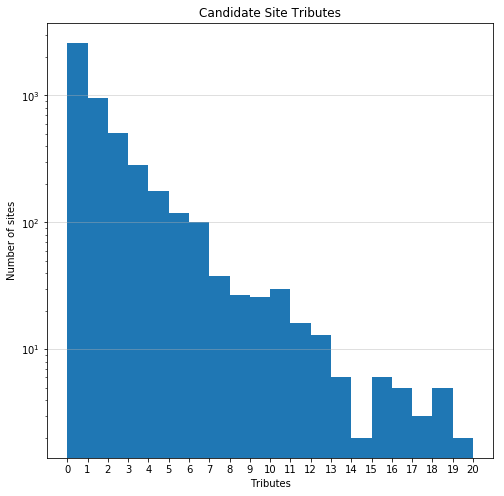

In [46]:
title = "Candidate Site Tributes"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = df_subset['numTributes'].fillna(0)
patches = plt.hist(x, log=True, range=(0, 20), bins=20)
ax.set_title(title)
ax.set_xlabel("Tributes")
ax.set_ylabel("Number of sites")

ax.set_xticks(range(0,21,1))

ax.grid(axis="y", alpha=0.5)
plt.show()

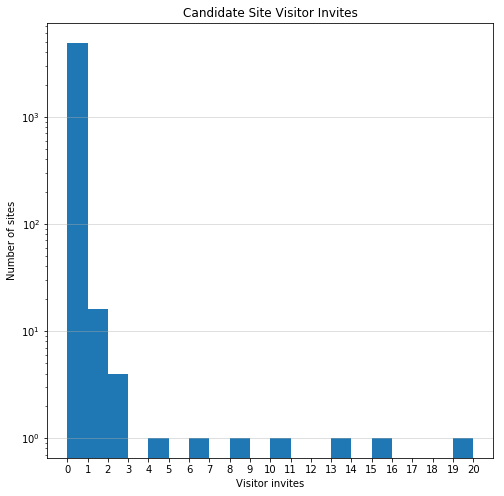

In [47]:
title = "Candidate Site Visitor Invites"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = df_subset['numVisitorInvites'].fillna(0)
patches = plt.hist(x, log=True, range=(0,20), bins=20)
ax.set_title(title)
ax.set_xlabel("Visitor invites")
ax.set_ylabel("Number of sites")

ax.set_xticks(range(0,21,1))

ax.grid(axis="y", alpha=0.5)
plt.show()

## IRR set identification

In [ ]:
random.seed(1000)
random.shuffle(valid_sites)
len(valid_sites)

In [ ]:
irr_set_size = 10
irr_set = valid_sites[:irr_set_size]
irr_set.sort()
irr_set

In [ ]:
irr_df = df_subset[df_subset['_id'].isin(irr_set)]
assert len(irr_df) == irr_set_size
irr_df = irr_df.sort_values(by=['_id'])
irr_df = irr_df[['_id', 'title', 'visits', 'numJournals', 'annotation_url']]

pd.set_option('display.max_colwidth', -1)  # allow the entirety of the url to show by removing column width limits
HTML(irr_df.to_html(escape=False))

In [ ]:
# write the irr_set as an assignment to the appropriate users
irr_assigned_users = ['levon003', 'rubya001']
base_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments"
header = "3: Fourth IRR set (tag for both phases and responsibilities)"
for user in irr_assigned_users:
    irr_filename = "irr_set_4_20180901.txt"
    irr_filepath = os.path.join(base_dir, user, irr_filename)
    with open(irr_filepath, 'w') as outfile:
        outfile.write(header + "\n")
        outfile.write("\n".join([str(sid) for sid in irr_set]))
print("Finished.")

In [ ]:
# what health conditions are included in this set?
irr_df = df_subset[df_subset['_id'].isin(irr_set)]
Counter(irr_df['healthCondition_name']).most_common()

In [ ]:
raise ValueError("This cell is a protection against accidentally running all the cells in this notebook.")

## Phase set for Wenqi

This section added to generate a random set of sites for phase annotation.

In [3]:
valid_sites = [int(line.strip()) for line in open(valid_sites_filtered_filename, 'r').readlines() if line.strip() != ""]
len(valid_sites)

4946

In [7]:
selected_sites = np.random.choice(valid_sites, size=50)
selected_sites[:10]

array([188675, 200697, 832045, 479074, 254110, 201608, 511451, 159835,
       274818, 306606])

In [8]:
irr_assigned_users = ['levon003', 'luoxx498']
base_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments"
header = "Phases 5: Sites for phase annotation"
for user in irr_assigned_users:
    filename = "phases_set_5_20180904.txt"
    filepath = os.path.join(base_dir, user, filename)
    with open(filepath, 'w') as outfile:
        outfile.write(header + "\n")
        outfile.write("\n".join([str(sid) for sid in selected_sites]))
print("Finished.")

Finished.


## Phase set for active learning

In [4]:
valid_sites = [int(line.strip()) for line in open(valid_sites_filtered_filename, 'r').readlines() if line.strip() != ""]
len(valid_sites)

4946

In [5]:
n = 1000
selected_sites = np.random.choice(valid_sites, size=n)
selected_sites[:10]

array([135757, 120611, 480360, 711193, 849336, 374280, 838612, 366721,
       257935, 535241])

In [7]:
active_learning_set_filepath = os.path.join(working_dir, 'active_learning_set_%d.txt' % n)
print(active_learning_set_filepath)
with open(active_learning_set_filepath, 'w') as outfile:
    outfile.write("\n".join([str(sid) for sid in selected_sites]))
print("Finished.")

/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites/active_learning_set_1000.txt
Finished.


## Multiset 2 for Sabirat

This section added to generate a random set of sites for phase and responsibility annotation.

In [3]:
valid_sites = [int(line.strip()) for line in open(valid_sites_filtered_filename, 'r').readlines() if line.strip() != ""]
len(valid_sites)

4946

In [4]:
selected_sites = np.random.choice(valid_sites, size=20)
selected_sites

array([ 377726,  196373,  172671,  549387,  129985, 1016139,  397600,
        372848,  239130,  142712,  690079,  361879,  396746,  843843,
        163893,  996965,  277108,  176087,  466538,  941782])

In [5]:
irr_assigned_users = ['rubya001']
base_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments"
header = "Multiset 2: Sites for phase and responsibility annotation"
for user in irr_assigned_users:
    filename = "multiset_2_20181009.txt"
    filepath = os.path.join(base_dir, user, filename)
    with open(filepath, 'w') as outfile:
        outfile.write(header + "\n")
        outfile.write("\n".join([str(sid) for sid in selected_sites]))
print("Finished.")

Finished.


## Multiset 3 for Wenqi and Drew

In [3]:
valid_sites = [int(line.strip()) for line in open(valid_sites_filtered_filename, 'r').readlines() if line.strip() != ""]
len(valid_sites)

4946

In [4]:
selected_sites = np.random.choice(valid_sites, size=20)
selected_sites

array([ 444370,  226963,  208865, 1031178,  260918,  106710,  241536,
        565371,  131547,  465780,  850650,  136046, 1034840,  853217,
        410698,  655867,  612427,  215287, 1024209,  235240])

In [5]:
irr_assigned_users = ['eriks074', 'luoxx498']
base_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments"
header = "Multiset 3: Sites for phase and responsibility annotation"
for user in irr_assigned_users:
    filename = "multiset_3_20181019.txt"
    filepath = os.path.join(base_dir, user, filename)
    with open(filepath, 'w') as outfile:
        outfile.write(header + "\n")
        outfile.write("\n".join([str(sid) for sid in selected_sites]))
print("Finished.")

Finished.


## Multiset 4 for Wenqi and Drew

In [3]:
valid_sites = [int(line.strip()) for line in open(valid_sites_filtered_filename, 'r').readlines() if line.strip() != ""]
len(valid_sites)

4946

In [4]:
selected_sites = np.random.choice(valid_sites, size=20)
selected_sites

array([161454, 537539, 230820, 921385, 302124, 198138, 561373, 820897,
       376170, 197260, 181230, 630153, 376466, 186370, 812280, 139736,
       225553, 322976, 635531, 192780])

In [5]:
irr_assigned_users = ['eriks074', 'luoxx498']
base_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments"
header = "Multiset 4: Sites for responsibility annotation"
for user in irr_assigned_users:
    filename = "multiset_4_20181206.txt"
    filepath = os.path.join(base_dir, user, filename)
    with open(filepath, 'w') as outfile:
        outfile.write(header + "\n")
        outfile.write("\n".join([str(sid) for sid in selected_sites]))
print("Finished.")

Finished.
